# Preface

In [7]:
# IMPORTS
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 150 # helpful for itemsets
from mlxtend.association import apriori, association_rules
from collections import Counter
from scipy.io.arff import loadarff
import arff
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

# DATA IMPORT
dt_basket = pd.read_excel("../data/ShoppingBaskets.xls", index_col=0)
dt_adults = pd.DataFrame(arff.load(open('../data/adult-dataset-tweaked.arff', 'r'))["data"], 
                         columns = pd.DataFrame(loadarff("../data/adult-dataset-tweaked.arff")[0]).columns)

# <span style="color:red";>TO BE REFACTORED</span>

In [40]:
def get_associated_items(dt, item):
    """"""
    itemcount_dict = Counter([item for itemsets in dt.values for item in itemsets])
    itemcount_dict.pop(item)
    return itemcount_dict

def filter_frequent_itemsets(df_itemsets, items, exact=False):
    """"""
    frozenset_vect = np.vectorize(lambda x: frozenset(x))
    df_tmp = frozenset_vect(df_itemsets.loc[:, ["itemsets"]])
    
    if exact:
        equality_vect = np.vectorize(lambda x,y: x == y)
        return df_itemsets[equality_vect(df_tmp, frozenset(items))]
    else:
        intersect_vect = np.vectorize(lambda x,y: len(x.intersection(y)) > 0)
        return df_itemsets[intersect_vect(df_tmp, frozenset(items))]

def filter_rules_by_items(df_rules, items, criteria="all", exact=True):
    """"""
    df_tmp = df_rules.loc[:, ["antecedants", "consequents"]].applymap(lambda x: list(x))
        
    if criteria == "all":
        supersets = np.array(df_tmp["antecedants"] + df_tmp["consequents"])
    elif criteria == "antecedants":
        supersets = np.array(df_tmp["antecedants"])
    elif criteria == "consequents":
        supersets = np.array(df_tmp["consequents"])
    else:
        raise ValueError("Criteria must be 'all', 'antecedants' or 'consequents', got{}"
                        .format(criteria))
   
    frozenset_vect = np.vectorize(lambda x: frozenset(x))
    
    if exact:
        equality_vect = np.vectorize(lambda x,y: x == y)
        df_res = df_rules[equality_vect(frozenset_vect(supersets), set(items))]
    else:
        intersect_vect = np.vectorize(lambda x,y: len(x.intersection(y)) > 0)
        df_res = df_rules[intersect_vect(frozenset_vect(supersets), set(items))]
    return df_res

def bin_to_range(x, bins, right=False, mapping=None):
    """x: array like
    """
    arr_binned = np.digitize(x, bins, right=right)
    
    if mapping:
        map_label_vect = np.vectorize(lambda arr, lbl_dict: lbl_dict[arr])
        map_dict = {}
        for idx, b in enumerate(np.unique(arr_binned)):
            map_dict[b] = mapping[idx]
        arr_binned = map_label_vect(arr_binned, map_dict)
            
    return arr_binned

---
# Task 4.1: Shopping Basket – Frequent Itemsets
We want to analyse the buying behavior of our customers. The Shopping Baskets dataset describes the content of ten baskets, which are identified by the BasketNo attribute. The ten transactions altogether contain ten different items (products), while the corresponding attribute in the dataset states whether or not an item is included in a specific basket. Import the data into RapidMiner using the Read Excel operator. Please ensure that the attribute types and roles are set correctly. As a first task, we want to mine frequent itemsets using the FP-Growth operator with the parameter support set to 0.2 and the parameter positive value set of to 1. Which items are usually bought together with the laptop (ThinkPad X220), the netbook (Asus EeePC) and the printer (HP Laserjet P2055)?

<span style="color:#AAAAAA;">Comment: Since FP-Growth is not easily & reliably available, APRIORI is used with a minsup of 0.2</span>

In [8]:
# Generate the frequent itemset
dt_freq_basket = apriori(dt_basket, min_support=0.2, use_colnames=True)

# Filter by ThinkPad X220
mask_tp220 = dt_freq_basket["itemsets"].map(lambda iset: "ThinkPad X220 " in iset) #! last char is [space]
dt_freq_basket_tp220= dt_freq_basket[mask_tp220]
print("ThinkPad X220: \n{}\n\n".format(get_associated_items(dt_freq_basket_tp220["itemsets"], "ThinkPad X220 ")))

# Filter by Asus EeePC
mask_aepc = dt_freq_basket["itemsets"].map(lambda iset: "Asus EeePC" in iset)
dt_freq_basket_aepc = dt_freq_basket[mask_aepc]
print("Asus EeePC: \n{}\n\n".format(get_associated_items(dt_freq_basket_aepc["itemsets"], "Asus EeePC")))

# Filter by HP Laserjet P2055
mask_hplj = dt_freq_basket["itemsets"].map(lambda iset: "HP Laserjet P2055" in iset)
dt_freq_basket_hplj = dt_freq_basket[mask_hplj]
print("HP Laserjet P2055: \n{}".format(get_associated_items(dt_freq_basket_hplj["itemsets"], "HP Laserjet P2055")))

ThinkPad X220: 
Counter({'Lenovo Tablet Sleeve': 4, 'HP Laserjet P2055': 4, 'HP CE50 Toner': 4, 'LT Laser Maus': 1, '8 GB DDR3 RAM': 1})


Asus EeePC: 
Counter({'Netbook-Schutzhülle ': 6, '2 GB DDR3 RAM': 6, 'LT Minimaus': 4, 'LT Laser Maus': 4})


HP Laserjet P2055: 
Counter({'Lenovo Tablet Sleeve': 4, 'HP CE50 Toner': 4, 'ThinkPad X220 ': 4})


---
# Task 4.2: Shopping Basket – Association Rules
What can the created rules based on the former created itemsets tell you about the relationship between Asus EeePC, 2 GB DDR3 RAM extensions and the Netbook-Schutzhülle? Try to judge the interestingness of the rules based on the lift values.

## <span style="color:#AAAAAA;">Recap about lift</span>
The _lift_ value is defined as $$ lift(X \rightarrow Y) = \frac{confidence(X \rightarrow Y)}{\sigma(Y)}$$
where _confidence_ is defined as $$ confidence(X \rightarrow Y) = \frac{\sigma(X \cup Y)}{\sigma(X)} $$
and _$\sigma$_ is the support.<br><br>

Having this in mind, the lift values can be interpreted as a kind of directed correlation between the _ancedant_ and the _consequent_. The following cases can occur:
- lift < 1 meaning that the rule $X \rightarrow Y$ should rather be seen as $X \rightarrow \neg Y$
- lift = 1 meaning that ancedant and consequent of the rule $X \rightarrow $ are rather independent
- lift > 1 meaning that the rule $X \rightarrow Y$ should be definitively seen as $X \overset{!}{\rightarrow} Y$

In [48]:
dt_rules = association_rules(dt_freq_basket)
filter_rules_by_items(dt_rules, ["Asus EeePC", "2 GB DDR3 RAM", "Netbook-Schutzhülle "])

,antecedants,consequents,support,confidence,lift
21,"(Netbook-Schutzhülle , 2 GB DDR3 RAM)",(Asus EeePC),0.4,1.0,1.666667
22,"(Netbook-Schutzhülle , Asus EeePC)",(2 GB DDR3 RAM),0.4,1.0,2.000000
23,"(Asus EeePC, 2 GB DDR3 RAM)",(Netbook-Schutzhülle ),0.5,0.8,2.000000
24,(Netbook-Schutzhülle ),"(Asus EeePC, 2 GB DDR3 RAM)",0.4,1.0,2.000000
25,(2 GB DDR3 RAM),"(Netbook-Schutzhülle , Asus EeePC)",0.5,0.8,2.000000


Since all the lift values are greater than `1` none of the rules should be ommited and all rules can be considered "interesting".

---
# Task 4.3: Adult Dataset – Preprocessing
In the following, we will work with a tweaked version (less attributes and less examples, available as .arff-file in the exercise repository) of this original dataset. In order to make it feasible for frequent itemset mining and association rule analysis, some preprocessing steps need to be performed. After you have read the dataset by using the Read ARFF operator, you  first need to **discretize the age and the hours-per-week attributes into three user-defined ranges**. Based on the original purpose of the dataset, think about what ranges might make sense. As frequent itemset mining only works on binary attributes, **convert all attributes of the dataset into binary attributes.** How many attributes does the dataset contain after executing the described preprocessing steps?

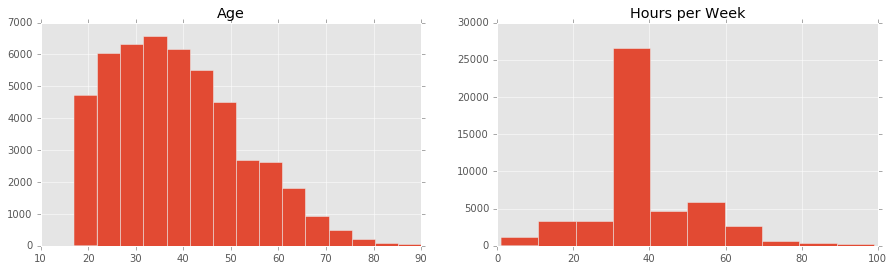

In [12]:
# setup the plot
fig, axes = plt.subplots(1,2)
fig.set_figwidth(15)

# age histogram
axes[0].hist(dt_adults["age"], bins=15)
axes[0].set_title("Age")

# hpw histogram
axes[1].hist(dt_adults["hours-per-week"])
axes[1].set_title("Hours per Week")

plt.savefig("../figures/association/age-and-hpw-histogram.png")
plt.show()

## Suggested split of `age`
The histogram does not directly advice a certain split, therefore the following criteria should be considered:
- Age <= 25
- 25 < Age <= 50
- 50 < Age

## Suggested split of `hours-per-week`
Based on the histogram a possible split for hours-per-week (HWP) could be:
- HPW <= 30 
- 30 < HPW <= 40
- 40 < HPW

In [13]:
dt_adults["age"] = bin_to_range(dt_adults["age"],
                                bins=[0, 30, 40],
                                right=True,
                                mapping=["age <= 25", "25 < age <= 50", "50 < age"])
dt_adults["hours-per-week"] = bin_to_range(dt_adults["hours-per-week"],
                                           bins=[0, 30, 40],
                                           right=True,
                                           mapping=["hpw <= 30", "30 < hpw <= 40", "40 < hpw"])

Since the task only refers to the discretization of `age` and `hours-per-week` the following attributes are dropped:
- `fnlwgt`
- `education-num`
- `capital-gain`
- `capital-loss`.

In [14]:
dt_adults.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,age <= 25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,X,0.0,0.0,30 < hpw <= 40,United-States,X
1,age <= 25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,30 < hpw <= 40,United-States,<=50K
2,25 < age <= 50,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,40 < hpw,United-States,<=50K
3,age <= 25,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,30 < hpw <= 40,United-States,>50K
4,50 < age,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,30 < hpw <= 40,United-States,>50K


In [15]:
dt_adults.drop(["fnlwgt", "education-num", "capital-gain", "capital-loss"], axis=1, inplace=True)
dt_adults.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,class
0,age <= 25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,X,30 < hpw <= 40,United-States,X
1,age <= 25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,30 < hpw <= 40,United-States,<=50K
2,25 < age <= 50,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,40 < hpw,United-States,<=50K
3,age <= 25,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,30 < hpw <= 40,United-States,>50K
4,50 < age,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,30 < hpw <= 40,United-States,>50K


The next preprocessing step is the "one-hot-encoding" of all variables (easiest via `pd.get_dummies`).

In [16]:
dt_adults = pd.get_dummies(dt_adults)
print(dt_adults.shape)
dt_adults.head()

(48843, 109)


,age_25 < age <= 50,age_50 < age,age_age <= 25,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,class_<=50K,class_>50K,class_X
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Dimension after preprocessing
After binning the attributes `age` and `hours-per-week` into 3 bins (respectively) and one-hot-encoding the overall dimensions of the preprocessed DataFrame are **48843 Records** by **109 Attributes**

---
# Task 4.4: Adult Dataset – Frequent Itemsets
Make use of the FP-Growth operator to mine frequent itemsets with a support above 0.2. What can you learn from these itemsets about the people who earn less than $50 000?

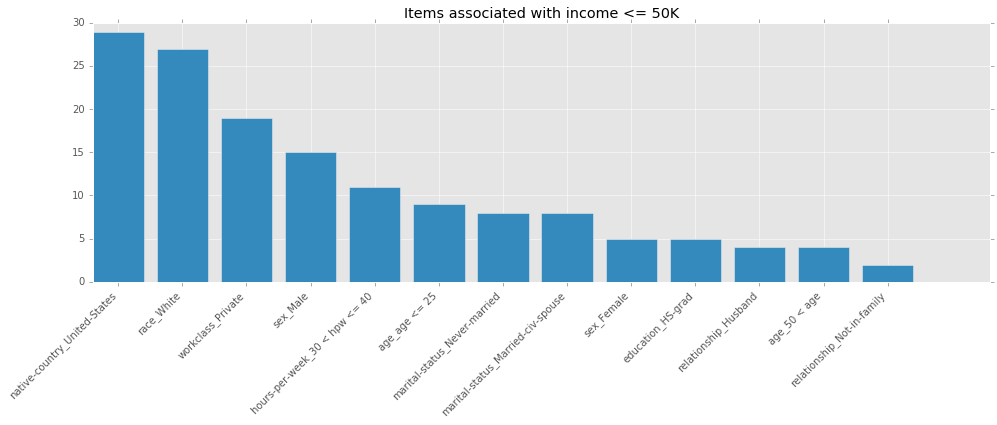

In [73]:
# get frequent itemsets and filter to get itemsets related to '<=50K'
dt_adults_freq_less_50K = filter_frequent_itemsets(
    apriori(dt_adults, min_support=0.2, use_colnames=True),
    ["class_<=50K"])

# extract items associated with '<=50K' 
assoc_items = get_associated_items(dt_adults_freq_less_50K["itemsets"], "class_<=50K")
assoc_items = [(assoc_items[k], k) for k in assoc_items.keys()]
assoc_items.sort(reverse=True)

# plot the bar chart
values = list(zip(*assoc_items))[0]
labels  = list(zip(*assoc_items))[1]
plt.rcParams["figure.figsize"] = [14, 6]
h = plt.bar(range(len(values)), values)
plt.title("Items associated with income <= 50K")
xticks_pos = [0.5*patch.get_width() + patch.get_xy()[0] for patch in h]
plt.xticks(xticks_pos, labels, ha="right", rotation=45, )
plt.tight_layout()
plt.savefig("../figures/association/less-50k-associated-items.png")
plt.show()

It seems as if people who earn less than 50K seem to be:
- born in the USA
- of "white race"
- of workclass "private"
- male
- 30 < hpw <= 40
- age <= 25

In [59]:
filter_rules_by_items(
    association_rules(
        apriori(
            dt_adults, 
            min_support=0.2, 
            use_colnames=True),
        metric="lift", min_threshold=1.25),
    ["class_<=50K"],
    criteria="antecedants",
    exact=True
)

,antecedants,consequents,support,confidence,lift
55,(class_<=50K),"(marital-status_Never-married, race_White)",0.760703,0.338339,1.250228
103,(class_<=50K),"(age_age <= 25, marital-status_Never-married)",0.760703,0.298748,1.292795
196,(class_<=50K),"(native-country_United-States, marital-status_Never-married)",0.760703,0.371928,1.254392
370,(class_<=50K),"(workclass_Private, native-country_United-States, marital-status_Never-married)",0.760703,0.281470,1.262078
552,(class_<=50K),(marital-status_Never-married),0.760703,0.414049,1.254709
583,(class_<=50K),"(age_age <= 25, native-country_United-States, marital-status_Never-married)",0.760703,0.268443,1.293309
614,(class_<=50K),"(workclass_Private, marital-status_Never-married)",0.760703,0.316377,1.262073


Extracting rules that solely rely on the atencedant "<=50K" reveals the following two things:
- The associated attributes are (like in the barchart) _born in the US, age<=25, 'white race', never merried, workclass private_
- The max lift value is around 1.29 indicating a slightly positive correlation of the rule. "More interesting" (higher lift score) rules can be found, if one does not for an `exact` match of "class\_<=50K" in the list of antecedants but rahter antecedants that contain "class\_<=50K" _(changing the `exact` parameter to `False`)

---
# Task 4.5: Adult Dataset – Further Preprocessing
From the resulting itemsets we can see, that, although we have a rather low minimal support threshold, the variation of different educations is rather low. We can mostly observe itemsets including HS-grad and almost no other educations.
Besides, also the native-country = United-States is dominant.
Try to explain the dominance of those two attributes and think about a possibility to aggregate the values further to reduce this dominance.

## Possible reasons for dominance
From the description of the dataset [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)):<br>

_This data set contains weighted census data extracted from the 1994 and 1995 Current Population Surveys conducted by the U.S. Census Bureau. The data contains 41 demographic and employment related variables._<br>

Since this data was generated in the US the most dominant native country is USA. The dominance of the education level "highschool" might be caused due to the fact, that _"Public high schools don't charge tuition"_[1] whereas other higher level institution like do charge a notably amount of money[2]

## Possible strategies to overcome dominance
A possible strategy to overcome the highly skewed distribution of either native country or highest education level is to **omit the records that contain either native-country = US or education = HS-grad**.

### References
[1] Cost of highschool - education expenes. http://education.costhelper.com/high-school.html<br>
[2] How much does it cost to study in the US. https://www.topuniversities.com/student-info/student-finance/how-much-does-it-cost-study-us

---
# Task 4.6: Adult Dataset – Finding Rich Americans
Use the FP-Growth must contain parameter to restrict the patterns to the ones containing class => 50K and lower the support so that a decent number of item- sets is discovered. What can you learn from these itemsets about the people who earn more than $50 000 per year?


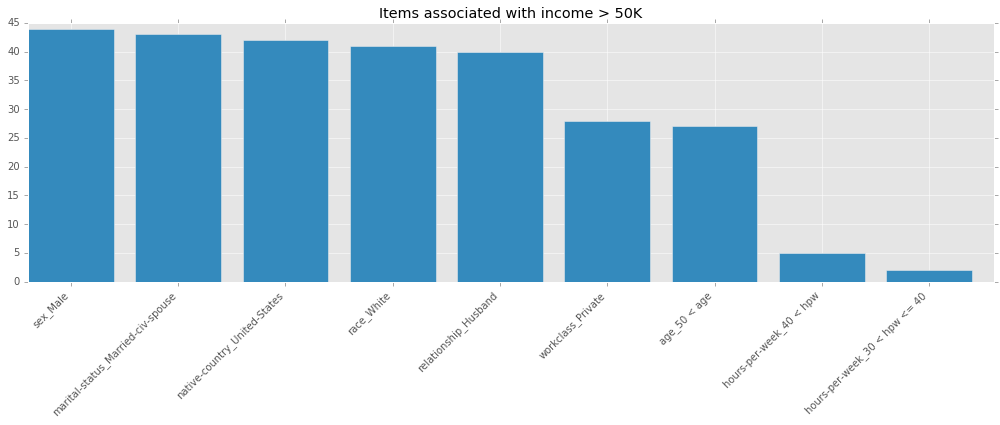

In [75]:
# get frequent itemsets and filter to get itemsets related to '<=50K'
dt_adults_freq_more_50K = filter_frequent_itemsets(
    apriori(
        dt_adults, 
        use_colnames=True, 
        min_support=0.1), 
    items=["class_>50K"])

# extract items associated with '>50K' 
assoc_items = get_associated_items(dt_adults_freq_more_50K["itemsets"], "class_>50K")
assoc_items = [(assoc_items[k], k) for k in assoc_items.keys()]
assoc_items.sort(reverse=True)

# plot the bar chart
values = list(zip(*assoc_items))[0]
labels  = list(zip(*assoc_items))[1]
plt.rcParams["figure.figsize"] = [14, 6]
h = plt.bar(range(len(values)), values)
plt.title("Items associated with income > 50K")
xticks_pos = [0.5*patch.get_width() + patch.get_xy()[0] for patch in h]
plt.xticks(xticks_pos, labels, ha="right", rotation=45, )
plt.tight_layout()
plt.savefig("../figures/association/more-50k-associated-items.png")
plt.show()

The vague observations that can be made is, that **in contrast to people earning less than 50K, people who earn more than 50K tend to be**:
- married (therefore a husband)
- older than 50 years
- working more than 40 hours per week

---
# Task 4.7: Adult Dataset – Association Rule Mining
As we have learned, looking only at the frequent itemsets might not reveal too many insights. Therefore, we now want to learn association rules. Apply the Create Association Rules operator to the process of the former task. Which rules do you consider to be interesting? Consider both => 50K and < 50K classes.